In [1]:
#pip install dataset


# Sales Forecasting TATA Training Kaggle Competition 

## Description

In this competition we will work with a challenging time-series dataset consisting of daily sales data,provided by one of the largest Russian software firms - 1C Company. 

## Objective 

To predict total sales for every product and store in the next month.

### Installing opendatasets 
<ul>
<li>To download and work on datasets on Jupyter we use opendatasets . 


In [2]:
#pip install opendatasets --upgrade

### Adding Necessary Libararies 

In [3]:
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,8
from tensorflow import keras
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras import optimizers


In [4]:
#od.download("https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales")

## Data Import

In [5]:
train_data=pd.read_csv(r'D:\Datasets\competitive-data-science-predict-future-sales\sales_train.csv')
test_data=pd.read_csv(r"D:\Datasets\competitive-data-science-predict-future-sales\test.csv")
submission=pd.read_csv(r"D:\Datasets\competitive-data-science-predict-future-sales\sample_submission.csv")
items=pd.read_csv(r"D:\Datasets\competitive-data-science-predict-future-sales\items.csv")
items_category=pd.read_csv(r"D:\Datasets\competitive-data-science-predict-future-sales\item_categories.csv")
shops=pd.read_csv(r"D:\Datasets\competitive-data-science-predict-future-sales\shops.csv")

## Primary EDA

In [6]:
train_data.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [7]:
#train_data.to_excel('tata_train_train_data.xlsx')

In [8]:
train_data.shape

(2935849, 6)

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [10]:
print("Median for all item_price",train_data.item_price.median())
x1=train_data[(train_data.shop_id == 32) & (train_data.item_id == 2973) & (train_data.date_block_num == 4) & (
            train_data.item_price > 0)].item_price.median()
print("Median for shop id 32 with item id 2973 and date block 4 where item price is >1 is ",x1)
x1=train_data[(train_data.shop_id == 32) & (train_data.item_id == 2973) & (train_data.date_block_num == 0) & (
            train_data.item_price > 0)].item_price.median()
print("Median for shop id 32 with item id 2973 and date block 0 where item price is >0 is",x1)

Median for all item_price 399.0
Median for shop id 32 with item id 2973 and date block 4 where item price is >1 is  1874.0
Median for shop id 32 with item id 2973 and date block 0 where item price is >0 is 2499.0


In [11]:
len((train_data.date_block_num))

2935849


 34 unique date_block_num
 
 21807 unique item_id
 
 60 unique shop id 

In [12]:
train_data.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [13]:
out_item_price=249-1.5*(999-249)
print(out_item_price)

-876.0


In [14]:
x23=train_data[train_data.item_price>1374]
print(len(x23))
(497701*100)/2935849

497701


16.95254081528035

## Outlier Calculation and detection

### Outlier detection using Histogram and BoxPlot

array([[<AxesSubplot:title={'center':'shop_id'}>,
        <AxesSubplot:title={'center':'item_id'}>],
       [<AxesSubplot:title={'center':'item_price'}>,
        <AxesSubplot:title={'center':'item_cnt_day'}>]], dtype=object)

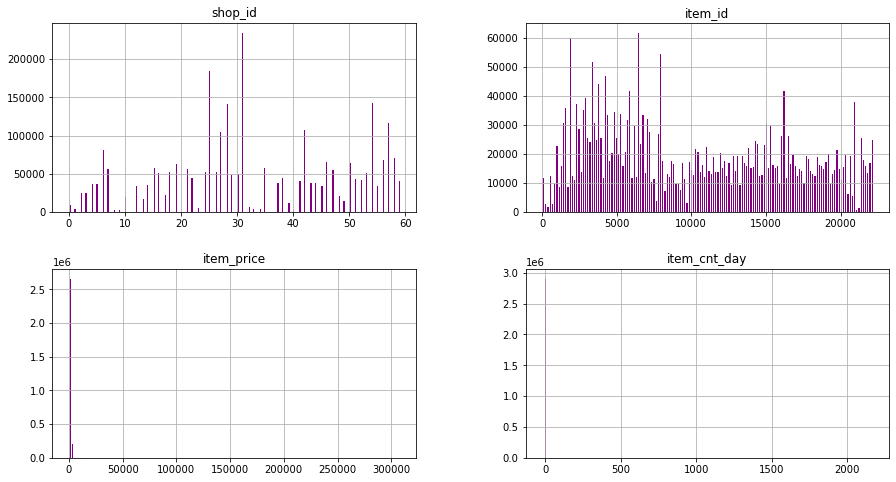

In [15]:
train_data[['shop_id','item_id','item_price','item_cnt_day']].hist(color='purple', edgecolor='white',bins=150)

In [16]:
fig1, ax = plt.subplots(1,2,dpi=1000)
train_data.item_price.plot(ax=ax[0]);
train_data.item_cnt_day.plot(ax=ax[1]);

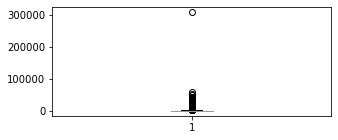

In [17]:
fig = plt.figure(figsize =(5, 2))
plt.boxplot(train_data.item_price)
plt.show()


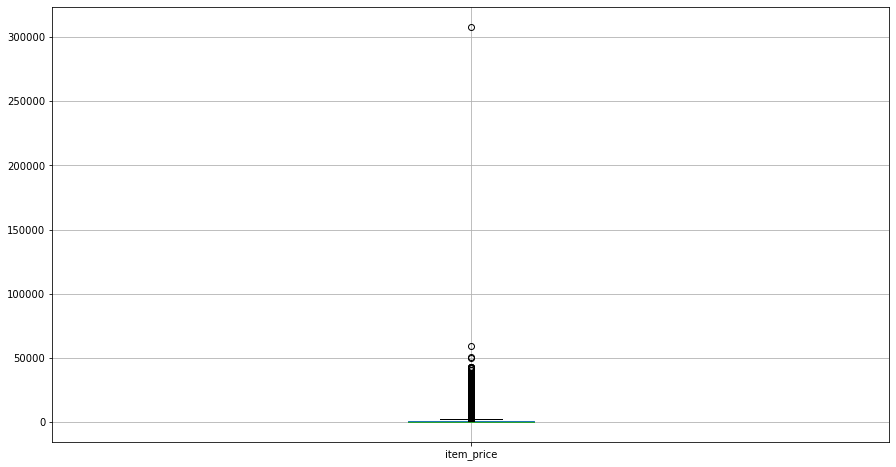

In [18]:
box_item_price= train_data.boxplot(column=['item_price'])

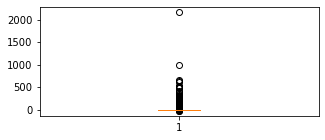

In [19]:
fig = plt.figure(figsize =(5, 2))
plt.boxplot(train_data.item_cnt_day)
plt.show()


### Outlier Calculation

Min = Q1 -1.5(Q3-Q1)

Max = Q1 +1.5(Q3-Q1)

Q1 = 25 percentile

Q3 = 75 percentile

In [20]:
item_price_25=np.percentile(train_data.item_price,25)
item_price_75=np.percentile(train_data.item_price,75)
outlier_item_price=item_price_25-1.5*(item_price_75-item_price_25)
print(outlier_item_price)

-876.0


In [21]:
min_outlier_item_price=np.percentile(train_data.item_price,25)-1.5*(np.percentile(train_data.item_price,75)-np.percentile(train_data.item_price,25))
max_outlier_item_price=np.percentile(train_data.item_price,25)+1.5*(np.percentile(train_data.item_price,75)-np.percentile(train_data.item_price,25))
outlier_item_price=train_data[(min_outlier_item_price>train_data.item_price) | (max_outlier_item_price<train_data.item_price)]
print(len(outlier_item_price))


497701


In [22]:
train_data.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [23]:
train_data.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


### Summary of Primary EDA
<ul>
    <li> <tt><b> .isnull().sum()</b></tt> There are no null values 
    <li> From <tt><b>.describe()</b></tt> Minimum Values are negative 
    <li> Clearly from above histograms and boxplot , we see that <tt><b>item_price</b></tt> and <tt><b> item_cnt_day</b></tt> have outliers.
</ul>


## Data Cleaning

### <u>Objectives</u> 

<ol>
    <li> Increase the relibilty of over all dataset</li>
        <ul> 
            <li> Remove Data items with higher standard deviation</li>
            <li> Remove data items with negative values </li>
    </ul>
    </ol>

In [24]:
train_data.drop(train_data[train_data.item_price >3*train_data.item_price.std()].index, inplace=True)
train_data.drop(train_data[train_data.item_cnt_day >3*train_data.item_cnt_day.std()].index, inplace=True)

In [25]:
train_data.drop(train_data[train_data.item_price <0].index, inplace=True)
train_data.drop(train_data[train_data.item_cnt_day <0].index, inplace=True)


In [26]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2878327 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 153.7+ MB


array([[<AxesSubplot:title={'center':'shop_id'}>,
        <AxesSubplot:title={'center':'item_id'}>],
       [<AxesSubplot:title={'center':'item_price'}>,
        <AxesSubplot:title={'center':'item_cnt_day'}>]], dtype=object)

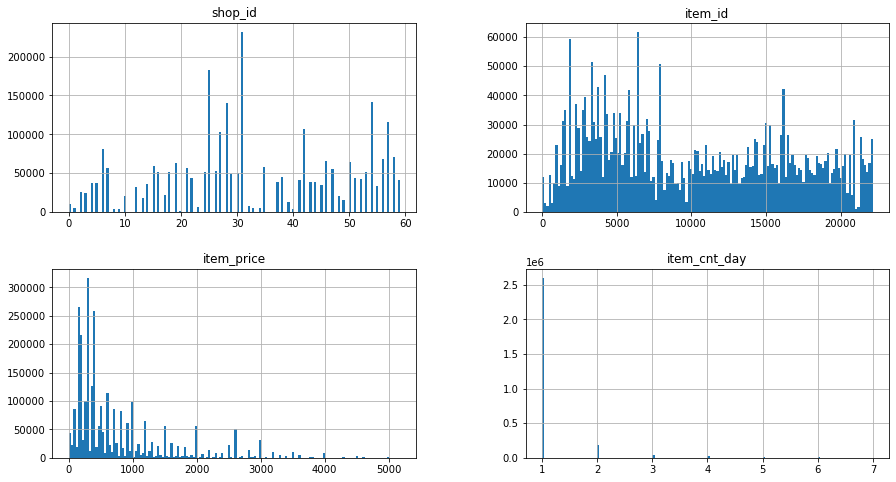

In [27]:
train_data[['shop_id','item_id','item_price','item_cnt_day']].hist(bins=150)

In [28]:
train_data.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.878327e+06,2.878327e+06,2.878327e+06,2.878327e+06,2.878327e+06
mean,1.453935e+01,3.302311e+01,1.019070e+04,7.440606e+02,1.152767e+00
std,9.426824e+00,1.622881e+01,6.333571e+03,7.852033e+02,5.747382e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e-02,1.000000e+00
25%,6.000000e+00,2.200000e+01,4.424000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.355000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.572800e+04,9.592000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,5.176000e+03,7.000000e+00


## Data Aggregation

We will make new dataframe and form <tt> monthly count</tt>

### Monthly Count 

<b>Objective</b>

<ol>
    <li> Creating Monthly Count </li>
    <ul> 
        <li> Merge Shop name with cities</li>
        <li> Group By <tt> "month", "date_block_num", "shop_id", "item_id", "item_price", "item_cnt_day" </tt> </li>
        <li> Aggregate each of newly formed columns</li>

In [29]:
shops=pd.read_csv(r"D:\Datasets\competitive-data-science-predict-future-sales\shops.csv")

In [30]:
shops.tail(15)

,shop_name,shop_id
45,"Самара ТЦ ""ПаркХаус""",45
46,"Сергиев Посад ТЦ ""7Я""",46
47,"Сургут ТРЦ ""Сити Молл""",47
48,"Томск ТРЦ ""Изумрудный Город""",48
49,"Тюмень ТРЦ ""Кристалл""",49
50,"Тюмень ТЦ ""Гудвин""",50
51,"Тюмень ТЦ ""Зеленый Берег""",51
52,"Уфа ТК ""Центральный""",52
53,"Уфа ТЦ ""Семья"" 2",53
54,"Химки ТЦ ""Мега""",54


In [31]:
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'

In [32]:
#shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
from sklearn.preprocessing import LabelEncoder
shops["city"] = LabelEncoder().fit_transform( shops.city);

In [33]:
shops['city'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [34]:
shops

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,0
1,"!Якутск ТЦ ""Центральный"" фран",1,0
2,"Адыгея ТЦ ""Мега""",2,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,2
4,"Волжский ТЦ ""Волга Молл""",4,3
5,"Вологда ТРЦ ""Мармелад""",5,4
6,"Воронеж (Плехановская, 13)",6,5
7,"Воронеж ТРЦ ""Максимир""",7,5
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,5
9,Выездная Торговля,9,6


In [35]:
dataFrame       = train_data.copy();
dataFrame["date"] = pd.to_datetime(dataFrame["date"],format='%d.%m.%Y');
dataFrame["month"] = dataFrame["date"].dt.month;

In [36]:
dataFrame.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
2935844,2015-10-10,33,25,7409,299.0,1.0,10
2935845,2015-10-09,33,25,7460,299.0,1.0,10
2935846,2015-10-14,33,25,7459,349.0,1.0,10
2935847,2015-10-22,33,25,7440,299.0,1.0,10
2935848,2015-10-03,33,25,7460,299.0,1.0,10


In [37]:
dataFrame = dataFrame[["month", "date_block_num", "shop_id", "item_id", "item_price", "item_cnt_day"]].groupby(
    ["date_block_num", "shop_id", "item_id"]).agg(
    {"item_price": "mean","item_cnt_day": "sum", "month": "min"}).reset_index();
dataFrame.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
0,0,0,32,221.0,6.0,1
1,0,0,33,347.0,3.0,1
2,0,0,35,247.0,1.0,1
3,0,0,43,221.0,1.0,1
4,0,0,51,128.5,2.0,1


In [38]:
dataFrame.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True);
dataFrame = pd.merge(dataFrame, items[['item_id','item_category_id']], how="inner");
dataFrame = pd.merge(dataFrame, shops[['shop_id','city']], how="inner");

dataFrame = dataFrame.sort_values(by=['date_block_num'], ascending=True).reset_index(drop=True);

#create pivot table
dataFrame = dataFrame.pivot_table(index = ['shop_id','item_id','city','item_category_id'],values = ['item_cnt_month'],columns = ['date_block_num'])
dataFrame.reset_index(inplace = True);


In [39]:
dataFrame.head(10)

shop_id item_id city item_category_id item_cnt_month            \
date_block_num                                                    0     1   2   
0                    0      30    0               40            NaN  22.0 NaN   
1                    0      31    0               37            NaN  11.0 NaN   
2                    0      32    0               40            6.0  10.0 NaN   
3                    0      33    0               37            3.0   3.0 NaN   
4                    0      35    0               40            1.0  14.0 NaN   
5                    0      36    0               37            NaN   1.0 NaN   
6                    0      40    0               57            NaN   1.0 NaN   
7                    0      42    0               57            NaN   1.0 NaN   
8                    0      43    0               40            1.0   NaN NaN   
9                    0      49    0               57            NaN   2.0 NaN   

                            ...                                          
date_block_num   3   4   5  ...  24  25  26  27  28  29  30  31  32  33  
0              NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1              NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2              NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
3              NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
4              NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
5              NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
6              NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
7              NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
8              NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
9              NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[10 rows x 38 columns]

dataFrame.shape

In [40]:
dataFrame.columns

MultiIndex([(         'shop_id', ''),
            (         'item_id', ''),
            (            'city', ''),
            ('item_category_id', ''),
            (  'item_cnt_month',  0),
            (  'item_cnt_month',  1),
            (  'item_cnt_month',  2),
            (  'item_cnt_month',  3),
            (  'item_cnt_month',  4),
            (  'item_cnt_month',  5),
            (  'item_cnt_month',  6),
            (  'item_cnt_month',  7),
            (  'item_cnt_month',  8),
            (  'item_cnt_month',  9),
            (  'item_cnt_month', 10),
            (  'item_cnt_month', 11),
            (  'item_cnt_month', 12),
            (  'item_cnt_month', 13),
            (  'item_cnt_month', 14),
            (  'item_cnt_month', 15),
            (  'item_cnt_month', 16),
            (  'item_cnt_month', 17),
            (  'item_cnt_month', 18),
            (  'item_cnt_month', 19),
            (  'item_cnt_month', 20),
            (  'item_cnt_month', 21),
            

## Making test data and train data of equal shape


In [41]:
test_data.columns

Index(['ID', 'shop_id', 'item_id'], dtype='object')

In [42]:
test_data = pd.merge(test_data, items[['item_id','item_category_id']], how="inner");
test_data = pd.merge(test_data, shops[['shop_id','city']], how="inner");
test_data.head()

,ID,shop_id,item_id,item_category_id,city
0,0,5,5037,19,4
1,1,5,5320,55,4
2,2,5,5233,19,4
3,3,5,5232,23,4
4,4,5,5268,20,4


In [43]:
test_data.columns

Index(['ID', 'shop_id', 'item_id', 'item_category_id', 'city'], dtype='object')

In [44]:
dataFrame = pd.merge(test_data,dataFrame,on = ['shop_id','item_id','city','item_category_id'],how = 'left');
dataFrame.fillna(0,inplace = True);

# change column names

columns = list(dataFrame.columns[0:4]);
for i in range(34):
    columns.append('time'+str(i))

dataFrame = dataFrame.rename(columns=dict(zip(list(dataFrame.columns),columns),inplace=True))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21520\2367394897.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  dataFrame = pd.merge(test_data,dataFrame,on = ['shop_id','item_id','city','item_category_id'],how = 'left');
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21520\2367394897.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dataFrame = pd.merge(test_data,dataFrame,on = ['shop_id','item_id','city','item_category_id'],how = 'left');


In [45]:
dataFrame.columns

Index([                  'ID',              'shop_id',              'item_id',
           'item_category_id',                'time0',                'time1',
                      'time2',                'time3',                'time4',
                      'time5',                'time6',                'time7',
                      'time8',                'time9',               'time10',
                     'time11',               'time12',               'time13',
                     'time14',               'time15',               'time16',
                     'time17',               'time18',               'time19',
                     'time20',               'time21',               'time22',
                     'time23',               'time24',               'time25',
                     'time26',               'time27',               'time28',
                     'time29',               'time30',               'time31',
                     'time32',               'time33

In [46]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   ID                214200 non-null  int64
 1   shop_id           214200 non-null  int64
 2   item_id           214200 non-null  int64
 3   item_category_id  214200 non-null  int64
 4   city              214200 non-null  int32
dtypes: int32(1), int64(4)
memory usage: 9.0 MB


In [47]:
test_data.head()

,ID,shop_id,item_id,item_category_id,city
0,0,5,5037,19,4
1,1,5,5320,55,4
2,2,5,5233,19,4
3,3,5,5232,23,4
4,4,5,5268,20,4


In [48]:
dataFrame.head()

,ID,shop_id,item_id,item_category_id,time0,time1,time2,time3,time4,time5,...,time25,time26,time27,time28,time29,time30,time31,time32,time33,"(item_cnt_month, 33)"
0,0,5,5037,19,4,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,55,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,19,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,23,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,20,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
dataFrame = dataFrame.drop(list(dataFrame.columns[0:4]), axis=1).copy();
dataFrame.head()

,time0,time1,time2,time3,time4,time5,time6,time7,time8,time9,...,time25,time26,time27,time28,time29,time30,time31,time32,time33,"(item_cnt_month, 33)"
0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


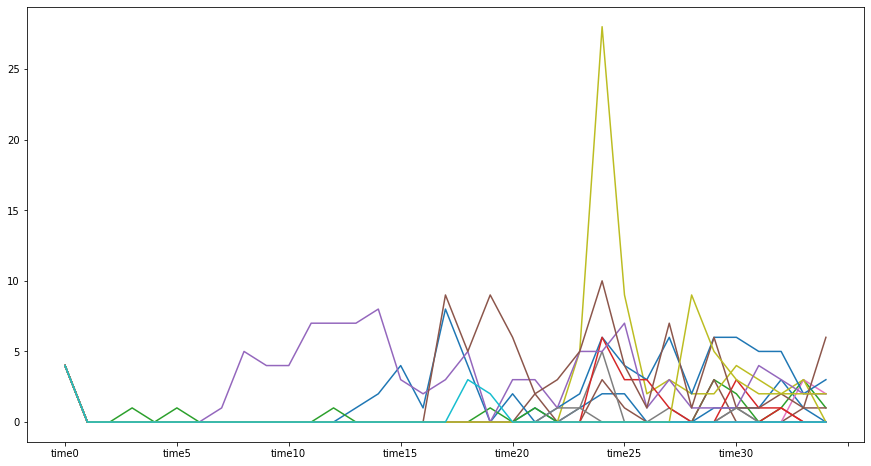

In [50]:
for i in range(20):
    dataFrame.loc[i].plot()

In [51]:
lag0 = dataFrame.T.copy()
lag0.head()

,0,1,2,3,4,5,6,7,8,9,...,214190,214191,214192,214193,214194,214195,214196,214197,214198,214199
time0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0
time1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
time2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
time3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
time4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
#lag0 = dataFrame.T.copy()

lag1 = lag0.shift(1,axis=0)
lag1.fillna(0,inplace = True)
lag1.index = lag1.index.astype('string')+'_lag1'

lag2 = lag0.shift(2,axis=0);lag2.fillna(0,inplace = True)
lag2.index = lag2.index.astype('string')+'_lag2'

lag3 = lag0.shift(3,axis=0);lag3.fillna(0,inplace = True);
lag3.index = lag3.index.astype('string')+'_lag3';

lag4 = lag0.shift(4,axis=0);lag4.fillna(0,inplace = True);
lag4.index = lag4.index.astype('string')+'_lag4';

lag5 = lag0.shift(5,axis=0);lag5.fillna(0,inplace = True);
lag5.index = lag5.index.astype('string')+'_lag5';

lag6 = lag0.shift(6,axis=0);lag6.fillna(0,inplace = True);
lag6.index = lag6.index.astype('string')+'_lag6';

lag7 = lag0.shift(7,axis=0);lag7.fillna(0,inplace = True);
lag7.index = lag7.index.astype('string')+'_lag7';

df = pd.concat((lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7),axis=0).T;

In [53]:
df.head(10)

,time0,time1,time2,time3,time4,time5,time6,time7,time8,time9,...,time25_lag7,time26_lag7,time27_lag7,time28_lag7,time29_lag7,time30_lag7,time31_lag7,time32_lag7,time33_lag7,"('item_cnt_month', 33)_lag7"
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,3.0,1.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,1.0
8,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,28.0,9.0,2.0,3.0
9,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
X_train = np.expand_dims(df.drop(columns=['time33','time33_lag1','time33_lag2','time33_lag3','time33_lag4','time33_lag5',
                                          'time33_lag6','time33_lag7'], axis=1).values,axis=2);
y_train = np.array(df['time33']);

In [65]:
len(X_train[0])

272

In [55]:
j=0
for i in y_train:
    j=j+1
print(j)
    

214200


In [56]:
X_test = np.expand_dims(df.drop(columns=['time0','time0_lag1','time0_lag2','time0_lag3','time0_lag4','time0_lag5',
                                          'time0_lag6','time0_lag7'], axis=1).values,axis=2);

### Modeling On LSTM

In [57]:
LSTM_model = Sequential();
LSTM_model.add(LSTM(units = 16,input_shape = (272,1)));
LSTM_model.add(Dense(10,activation='sigmoid')); # hidden layer
LSTM_model.add(Dropout(0.2));
LSTM_model.add(Dense(1,activation='sigmoid')); # output layer
hyper_opt = keras.optimizers.Adam(learning_rate=0.1);
LSTM_model.compile(loss = 'mean_squared_error',optimizer = hyper_opt, metrics = ['mean_squared_error']);
LSTM_model.fit(X_train,y_train,batch_size = 4096,epochs = 15);

Epoch 1/15
53/53 [==============================] - 85s 2s/step - loss: 1.7305 - mean_squared_error: 1.7305
Epoch 2/15
53/53 [==============================] - 93s 2s/step - loss: 1.7018 - mean_squared_error: 1.7018
Epoch 3/15
53/53 [==============================] - 94s 2s/step - loss: 1.7004 - mean_squared_error: 1.7004
Epoch 4/15
53/53 [==============================] - 44s 836ms/step - loss: 1.6983 - mean_squared_error: 1.6983
Epoch 5/15
53/53 [==============================] - 44s 823ms/step - loss: 1.7009 - mean_squared_error: 1.7009
Epoch 6/15
53/53 [==============================] - 44s 834ms/step - loss: 1.6988 - mean_squared_error: 1.6988
Epoch 7/15
53/53 [==============================] - 42s 797ms/step - loss: 1.6994 - mean_squared_error: 1.6994
Epoch 8/15
53/53 [==============================] - 43s 815ms/step - loss: 1.6988 - mean_squared_error: 1.6988
Epoch 9/15
53/53 [==============================] - 43s 809ms/step - loss: 1.6986 - mean_squared_error: 1.6986
Epoch 10/1

In [58]:
y_pred   = LSTM_model.predict(X_test);

6694/6694 [==============================] - 63s 9ms/step


In [73]:
ID=submission['ID']

In [61]:
submission=pd.DataFrame({'ID':ID,'item_cnt_month':y_pred.reshape(214200, )})

#submission = pd.DataFrame({'item_cnt_month': y_pred.reshape(214200, )});
submission.to_csv('submission.csv',index=False)

## Modeling on XGboost

In [59]:
y_pred

array([[0.3027415 ],
       [0.08832061],
       [0.08832061],
       ...,
       [0.19358952],
       [0.08831973],
       [0.0894614 ]], dtype=float32)

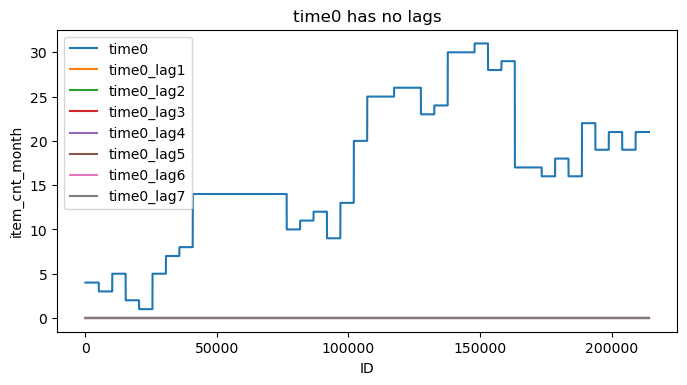

In [66]:
fig1, ax = plt.subplots(1,1,figsize=(8, 4),dpi=100)
time0_columns = df[['time0','time0_lag1','time0_lag2','time0_lag3','time0_lag4','time0_lag5','time0_lag6','time0_lag7']].copy();
time0_columns.plot(ax=ax);
ax.set_xlabel('ID');
ax.set_ylabel('item_cnt_month');
ax.set_title('time0 has no lags');

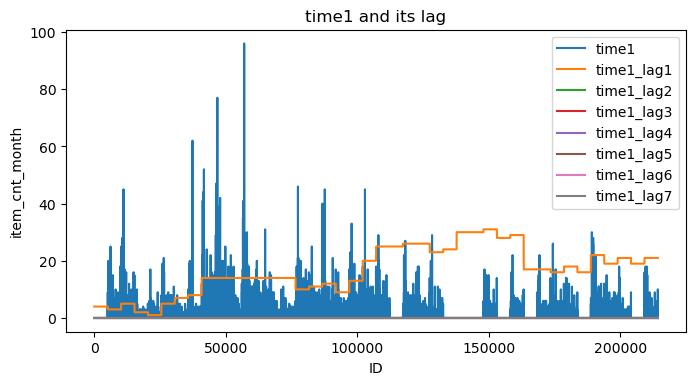

In [67]:
fig1, ax = plt.subplots(1,1,figsize=(8, 4),dpi=100)
time1_columns = df[['time1','time1_lag1','time1_lag2','time1_lag3','time1_lag4','time1_lag5','time1_lag6','time1_lag7']].copy();
time1_columns.plot(ax=ax);
ax.set_xlabel('ID');
ax.set_ylabel('item_cnt_month');
ax.set_title('time1 and its lag');

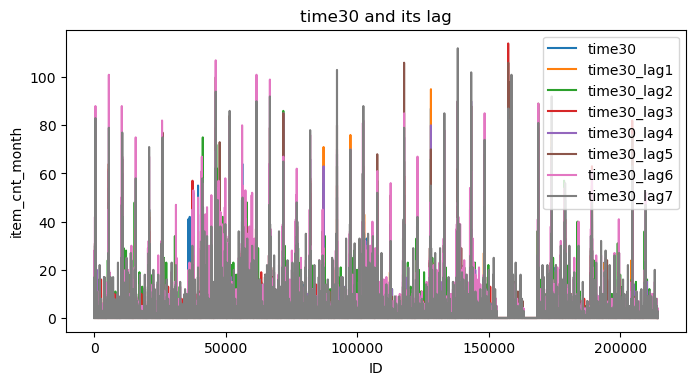

In [68]:
fig1, ax = plt.subplots(1,1,figsize=(8, 4),dpi=100)
time30_columns = df[['time30','time30_lag1','time30_lag2','time30_lag3','time30_lag4','time30_lag5','time30_lag6','time30_lag7']].copy();
time30_columns.plot(ax=ax);
ax.set_xlabel('ID');
ax.set_ylabel('item_cnt_month');
ax.set_title('time30 and its lag');

## PCA

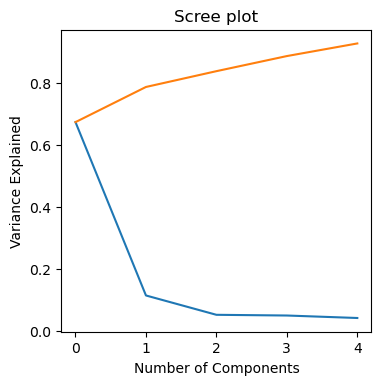

In [83]:
from sklearn.decomposition import PCA
fig1, ax = plt.subplots(1,1,figsize=(4, 4),dpi=100);
pca = PCA(n_components=5);
pca.fit(time30_columns);
variance = pca.explained_variance_ratio_;
variance_explained = np.cumsum(np.array(variance));
ax.plot(variance);
ax.plot(variance_explained);
ax.set_xlabel("Number of Components");
ax.set_ylabel("Variance Explained");
ax.set_title("Scree plot");

Two principle component already captures 80% of variability.

### Scaling and Dimension reduction using PCA

Lets scale before applying PCA and clip our values between 0 and 20.

In [71]:
from sklearn import preprocessing

In [72]:
df = df.clip(0,20);
scaler = preprocessing.StandardScaler();
scaled_df = scaler.fit_transform(df);
scaled_df = pd.DataFrame(scaled_df,columns = df.columns);

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


In [75]:
import xgboost as xgb

For testing model, we will have time0 to 32 as train and predict for 33

In [76]:
params = {'learning_rate': 0.02,
          'random_state': 10}
    
df_train = df.drop(columns=['time33','time33_lag1','time33_lag2','time33_lag3','time33_lag4','time33_lag5',
                                          'time33_lag6','time33_lag7'], axis=1).copy();
pca = PCA(n_components=5);
X_pca = pca.fit(df_train.T);
    
X_train = np.array(X_pca.components_).T;
y_train = np.array(scaled_df['time33']);

model_xgb = xgb.train(params,dtrain=xgb.DMatrix(np.array(X_train), np.array(y_train)));

y_pred   = model_xgb.predict(xgb.DMatrix(np.array(X_train))).clip(0,20);

from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(y_pred,y_train));
print(rmse)

1.0298713101703605


In [77]:
df_test = scaled_df.drop(columns=['time0','time0_lag1','time0_lag2','time0_lag3','time0_lag4','time0_lag5',
                                          'time0_lag6','time0_lag7'], axis=1);

In [78]:
X_pca_test = pca.fit(df_test.T);
X_test = np.array(X_pca_test.components_).T;


In [79]:
y_pred2   = model_xgb.predict(xgb.DMatrix(np.array(X_test))).clip(0,20);

In [80]:
ID=submission['ID']

In [81]:
submission=pd.DataFrame({'ID':ID,'item_cnt_month':y_pred.reshape(214200, )})

#submission = pd.DataFrame({'item_cnt_month': y_pred.reshape(214200, )});
submission.to_csv('submission_sale_xgboost.csv',index=False)

## Score Was 1.20096

project statement 
obj
explain data
eda
data cleaning
modelling
results
